In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from scipy import interpolate
from scipy.signal import hilbert
from scipy.signal import find_peaks

## Load data

In [106]:
#sin with noize.txt
#x = np.loadtxt("new_outputs/I_noize.txt")
#y = np.loadtxt("new_outputs/output_noize.txt")

#smooth sin.txt
x = np.loadtxt("new_outputs/I_sin.txt")
y = np.loadtxt("new_outputs/output_sin.txt")

#gauss.txt
#x = np.loadtxt("new_outputs/I_gauss.txt")
#y = np.loadtxt("new_outputs/output_gauss.txt")

#3days.txt
#x = np.loadtxt("new_outputs/I_3days.txt")
#y = np.loadtxt("new_outputs/output_3days.txt")

print(x.shape)
print(y.shape)

(2000, 200)
(40000, 64)


In [107]:
# non 3days.txt
y = y.reshape(2000,20,64)
#3days.txt
#y = y.reshape(6500,20,64)

In [108]:
data_boyarsk = pd.read_excel('data/boyarsk2021.xlsx')
data_machta = pd.read_excel('data/machta2020.xlsx')
data_ozone = pd.read_csv('data/ozone.csv', header=None)
nums = np.linspace(195, 555, 4344)
data_ozone['ind'] = nums

In [109]:
#gauss.txt
ticks_gauss = [
    "00:01", "00:38","01:15","01:52",
    "02:28","03:06","03:42","04:19",
    "04:56","05:33","06:10","06:47",
    "07:24","08:01","08:38","09:15",
    "09:52","10:29","11:06","11:43",
    "12:20","12:57","13:34","14:11",
    "14:48","15:25","16:02","16:39",
    "17:16","17:53","18:30","19:07",
    "19:44","20:21","20:58","21:35",
    "22:12","22:49","23:26"]

pos_gauss = np.linspace(0,584,len(ticks_gauss))
pos_gauss = pos_gauss[3:-4]
ticks_gauss = ticks_gauss[3:-4]

#sin.txt
label = data_boyarsk[data_boyarsk.columns[2]][76:781]
sin_labels = label[285:440]
ticks_sin = [str(item)[11:-3] for item in sin_labels]
pos_sin = np.linspace(15,584,155)

#3days.txt
three_days_labels = label[:440]
ticks_3days = [str(item)[5:-3] for item in three_days_labels]
pos_3days = np.linspace(0.8,580,440)+6

## Field measurements, 5 days

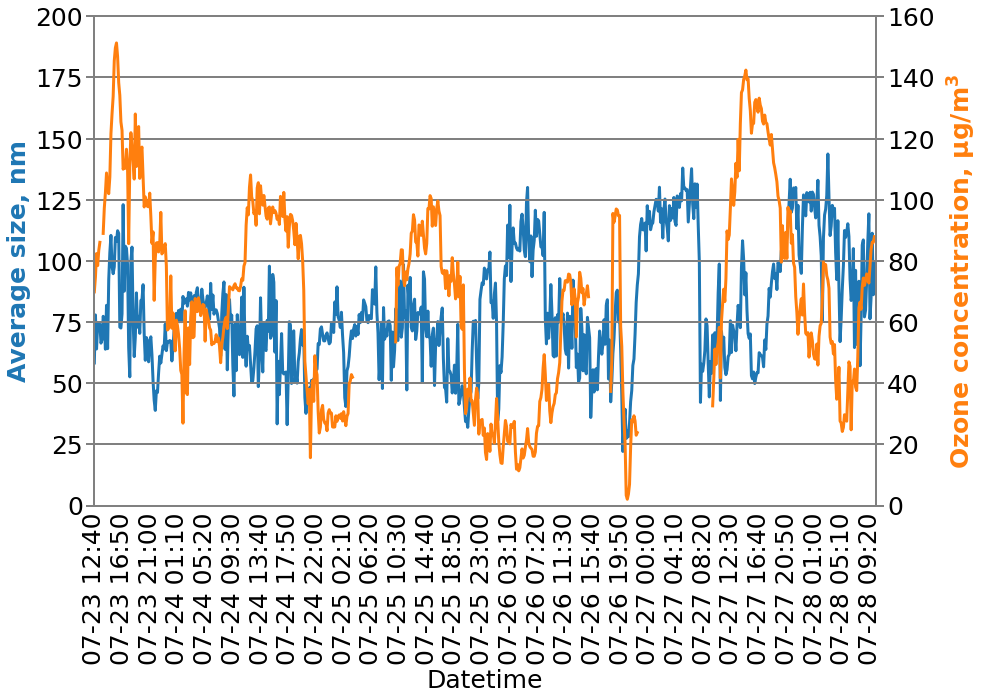

In [110]:
fig, ax1 = plt.subplots(figsize=(14,9))

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

ax2 = ax1.twinx()


plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

ax1.set_ylabel("Average size, nm", fontsize=25, color='C0', fontweight='bold')
ax2.set_ylabel("Ozone concentration, ${\mathbf{\mu g/m^3}}$", fontsize=25, color='C1', fontweight='bold')
ax2.yaxis.set_label_coords(1.09, 0.48)

ax2.grid(axis='y', lw=2, color='grey')


label_pos = np.arange(76, 781)
label = [str(item)[5:-3] for item in data_boyarsk[data_boyarsk.columns[2]][label_pos]]

ax2.plot(label_pos, data_boyarsk['O3 (2 м)'][76:781], color='C1', lw=3)
ax1.plot(label_pos, data_boyarsk['Dm'][76:781]*900000000, lw=3)
ax2.set_ylim([0,160])
ax1.set_ylim([0, 200])

ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')
ax2.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax2.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

ax1.set_xticks(ticks=label_pos[::25], labels=label[::25], va='center')
ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=75)
plt.xlim([76, 781])
ax1.set_xlabel("Datetime", fontsize=25)
plt.savefig("data.pdf", bbox_inches='tight', format='pdf')

## Data model mapping

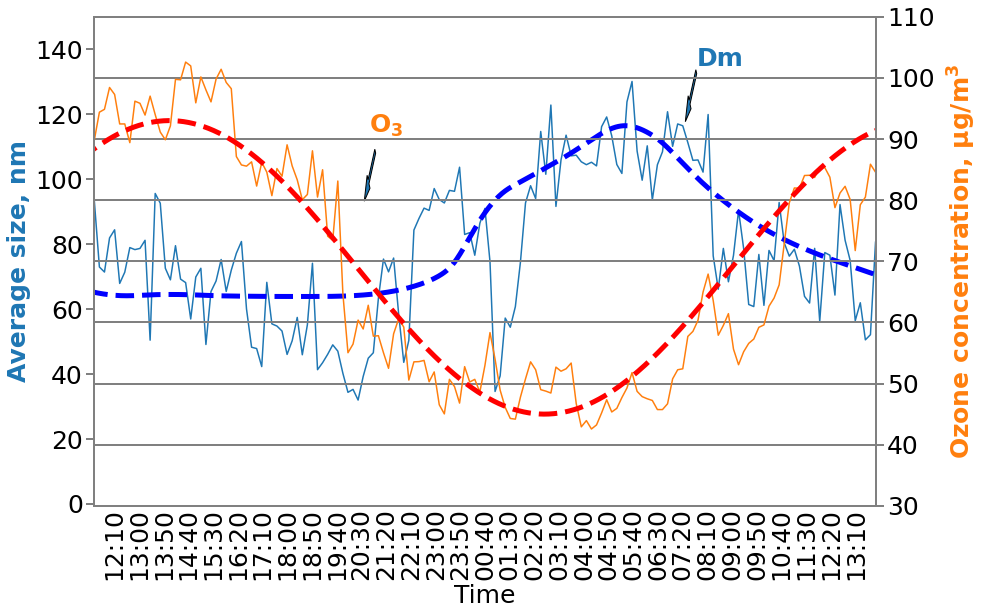

In [111]:
dm = np.array(data_boyarsk['Dm'])
dm_clip = dm[76:781]
o3 = np.array(data_boyarsk['O3 (2 м)'])#.fillna(0))
o3_clip = o3[76:781]

val = 14

fig, ax1 = plt.subplots(figsize=(14,9))


plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

#non 3days.txt
st = 1000
#3days.txt
#st = 500

sizes = (y[st:, val,:])*np.linspace(1,64,64)

ax2 = ax1.twinx()

#3days.txt
#ax1.plot(np.linspace(0, 584, 440), dm_clip[:440]*800000000-20)
#ax2.plot(np.linspace(0, 584, 440), o3_clip[:440]/1.5+35, 'C1')
#ax1.plot(np.linspace(0,584,6000), (sizes.mean(axis=1)/y[st:, val,:].mean(axis=1))*10-70, color='blue', linestyle='--', dashes=(5, 2), lw=5)
#ax2.plot(np.linspace(0,584,6000), x[500:,val*10]*1400+33, color='red', linestyle='--', dashes=(5, 5), lw=3)

#gauss.txt
#ax1.plot(np.arange(0, 584), data_machta['Dm']*900000000)
#ax2.plot(data_ozone['ind'][::5][:-100], data_ozone[1][::5][:-100]/1.5+25, 'C1')
#ax1.plot(np.linspace(-100,515,1000), (sizes.mean(axis=1)/y[st:, val,:].mean(axis=1))*45-420, 'b--', lw=5)
#ax2.plot(np.linspace(38,515,1000), x[st:,val*10]*2360-10, 'r--', lw=5)

#sin.txt
ax1.plot(np.linspace(0, 584, 155), dm_clip[285:440]*900000000)
ax2.plot(np.linspace(0, 584, 155), o3_clip[285:440]/1.5+35, 'C1')
#sin with noize.txt
#ax1.plot(np.linspace(0,584,1000), (sizes.mean(axis=1)/y[st:, val,:].mean(axis=1))*22-180, 'b--', lw=5)
#ax2.plot(np.linspace(0,584,1000), x[:,val*10][st:]*1400+31, 'r--', lw=5)
#smooth sin.txt
ax1.plot(np.linspace(-40,584,1000), (sizes.mean(axis=1)/y[st:, val,:].mean(axis=1))*11-50, 'b--', lw=5)
ax2.plot(np.linspace(-40,584,1000), x[:,val*10][st:]*600+45, 'r--', lw=5)

ax1.set_ylabel("Average size, nm", fontsize=25, color='C0', fontweight='bold')
ax2.set_ylabel("Ozone concentration, ${\mathbf{\mu g/m^3}}$", fontsize=25, color='C1', fontweight='bold')
ax2.yaxis.set_label_coords(1.09, 0.5)
ax2.grid(axis='y', lw=2, color='grey')
plt.yticks(fontsize=25)

#gauss.txt
#ax1.set_ylim([-0.6,200])
#ax2.set_ylim([20,160])
#sin.txt
ax1.set_ylim([-0.6,150])
ax2.set_ylim([30,110])
#3days.txt
#ax1.set_ylim([-0.6,100])
#ax2.set_ylim([20,160])

#gauss.txt
#ax1.set_xlim([40,515])
#ax2.set_xlim([40,515])
#sin.txt and 3days.txt
ax1.set_xlim([0,584])
ax2.set_xlim([0,584])


ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')
ax2.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax2.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

#gauss.txt
#plt.arrow(240,126,5,-5,width=0.9, head_width=3)
#plt.text(220,130, "$\mathbf{O_3}$", color='C1', fontsize=25, fontweight='bold')
#plt.arrow(480,116,-5,-5,width=0.9, head_width=3)
#plt.text(480,120, "Dm", color='C0', fontsize=25, fontweight='bold')
#sin.txt
plt.arrow(210,88,-5,-5,width=0.9, head_width=3)
plt.text(205,91, "$\mathbf{O_3}$", color='C1', fontsize=25, fontweight='bold')
plt.arrow(450,101,-5,-5,width=0.9, head_width=3)
plt.text(450,102, "Dm", color='C0', fontsize=25, fontweight='bold')

#gauss.txt
#ax1.set_xticks(ticks=pos_gauss[::1], labels=ticks_gauss[::1], va='center')
#ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=35)
#sin.txt
ax1.set_xticks(ticks=pos_sin[::5], labels=ticks_sin[::5], va='center')
ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=30)
#3days.txt
#ax1.set_xticks(ticks=pos_3days[::16], labels=ticks_3days[::16], va='center')
#ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=70)

#non 3days.txt
ax1.set_xlabel("Time", fontsize=25)
#3days.txt
#ax1.set_xlabel("Datetime", fontsize=25)

#sin with noize.txt
#plt.savefig("map_noize.pdf", bbox_inches='tight', format='pdf')
#smooth sin.txt
plt.savefig("map_sin.pdf", bbox_inches='tight', format='pdf')
#gauss.txt
#plt.savefig("gauss.pdf", bbox_inches='tight', format='pdf')
#3days.txt
#plt.savefig("3days.pdf", bbox_inches='tight', format='pdf')

## Resampling field data for model input

In [112]:
#import numpy as np
#import matplotlib.pyplot as plt
#import resampy
#a = np.loadtxt("data/1.txt")
#plt.plot(a)
#print(a.shape)
#interp_arr = resampy.resample(a, a.shape[0]*5, 6060*5)
#res = np.concatenate((np.ones(500)*interp_arr[30], interp_arr[30:-30]))
#plt.figure()
#plt.plot(res/80)
#print(res.shape)
#np.savetxt("data/1_resampled.txt", res/80)
#print(res.max())
#print(res.min())

In [113]:
#import resampy
#a = np.loadtxt("data/2.txt")
#plt.plot(a)
#print(a.shape)
#interp_arr = resampy.resample(a, a.shape[0]*5, 1020*5)
#plt.figure()
#plt.plot(interp_arr[10:-10])
#print(interp_arr.shape)
#np.savetxt("data/2_resampled.txt", interp_arr[10:-10]/80)
#interp_arr[10:-10].max()/8.67388
#print(interp_arr[10:-10].max())
#print(interp_arr[10:-10].min())

## Model predictions at different lengths

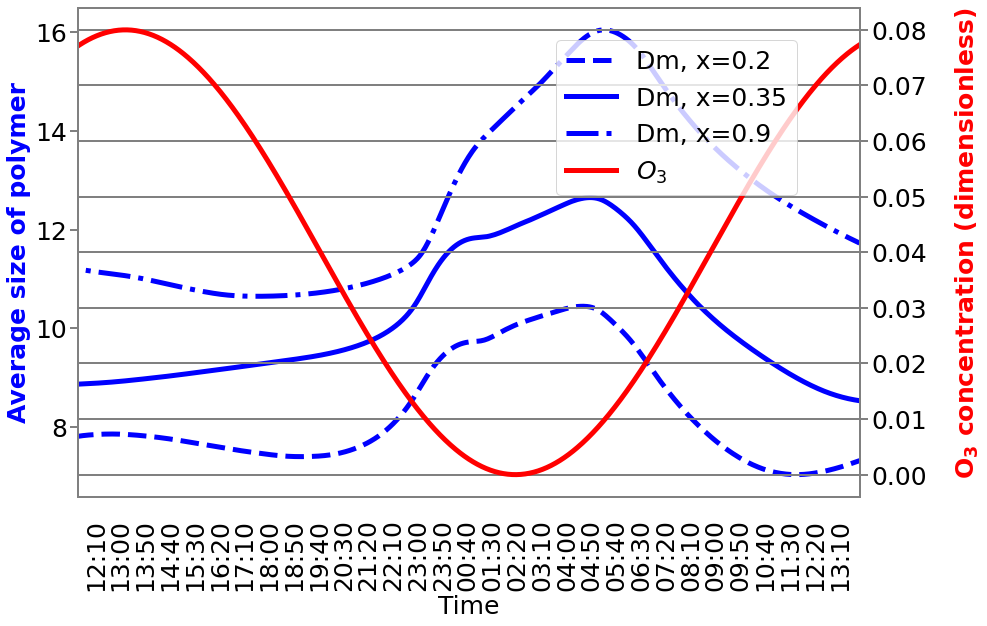

In [114]:
ticks_pos = np.linspace(0.12,1,len(ticks_sin))
ticks = ticks_sin


fig, ax1 = plt.subplots(figsize=(14,9))
st = 1000
en = 2000

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

coef = np.linspace(1,64,64)

val = 7
sizes = y[st:en,val,:]*coef

val_sm = 4
sizes_sm = y[st:en, val_sm,:]*coef

val_bg = 18
sizes_bg = y[st:en, val_bg,:]*coef

ax2 = ax1.twinx()


ax1.plot(np.linspace(0,1,en-st), sizes_sm.mean(axis=1)/y[st:en, val_sm,:].mean(axis=1), 'b--', label="Dm, x="+str(round(val_sm/20.,2)), lw=5)

ax1.plot(np.linspace(0,1,en-st), sizes.mean(axis=1)/y[st:en, val,:].mean(axis=1), 'b', label="Dm, x="+str(round(val/20.,2)), lw=5)

ax1.plot(np.linspace(0,1,en-st), sizes_bg.mean(axis=1)/y[st:en, val_bg,:].mean(axis=1), color='b', linestyle='dashdot', label="Dm, x="+str(round(val_bg/20.,2)), lw=5, markevery=0.04)

ax2.plot(np.linspace(0,1,en-st), x[st:en,val*10], 'r', label="$O_3$", lw=5)

ax1.set_ylabel("Average size of polymer", fontsize=25, color='blue', fontweight='bold')
ax2.set_ylabel("$\mathbf{O_3}$ concentration (dimensionless)", fontsize=25, color='red', fontweight='bold')

ax2.yaxis.set_label_coords(1.12, 0.52)

ax2.grid(axis='y', lw=2, color='grey')

plt.yticks(fontsize=25)

ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')
ax2.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax2.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

    
ax1.set_xticks(ticks=ticks_pos[::5], labels=ticks[::5], va='center')
ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=50)


ax1.set_xlim([0.1,1])
ax2.set_xlim([0.1,1])
ax1.set_xlabel("Time", fontsize=25)

fig.legend(fontsize=25, bbox_to_anchor=(0.35, 0.35, 0.5, 0.5))
plt.yticks(fontsize=25)
plt.savefig("num_ozon.pdf", bbox_inches='tight', format='pdf')


## Particle size distributions

(900, 64)
(100, 64)
(1000, 64)
(1000, 20)


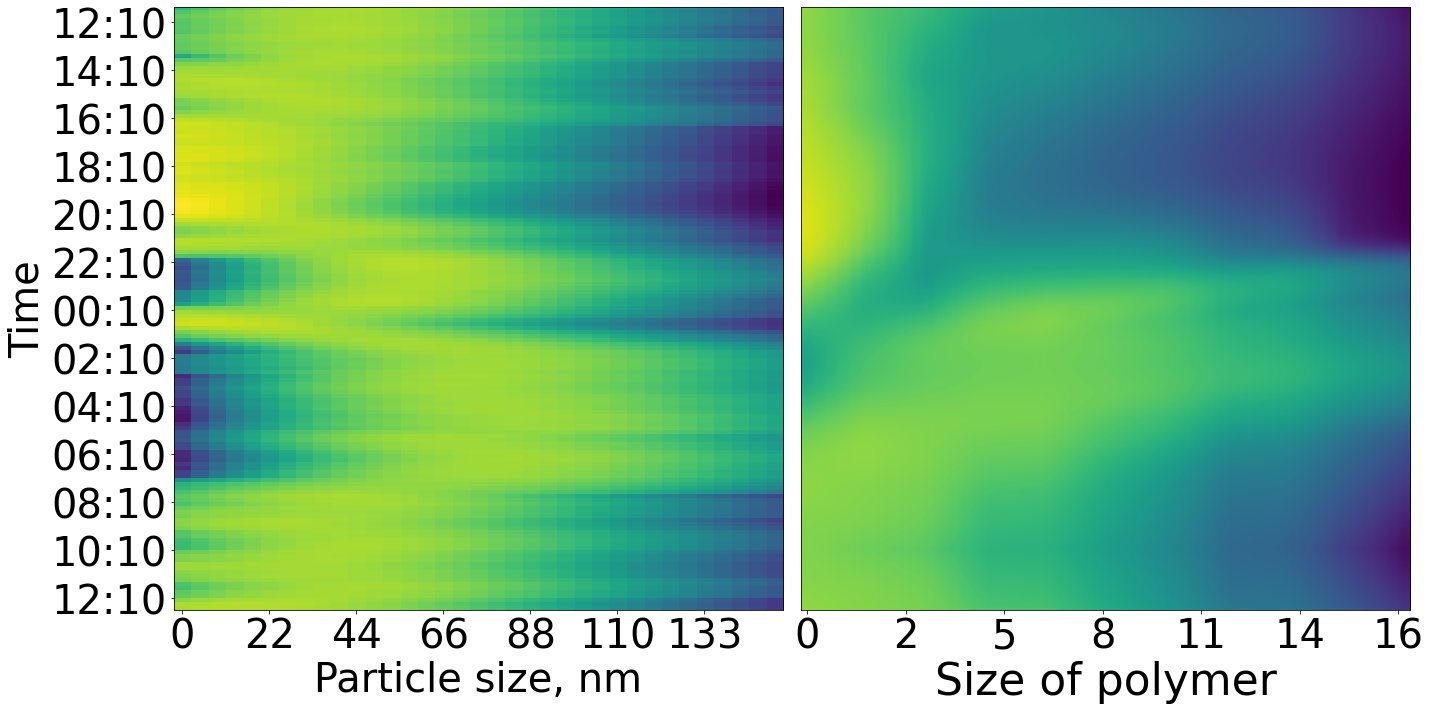

In [115]:
#THIS IS BASED ON SMOOTH SIN

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

sp_ticks=['0~5', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35~40',
       '40~45', '45~50', '50~55', '55~60', '60~65', '65~70', '70~75', '75~80',
       '80~85', '85~90', '90~95', '95~100', '100~105', '105~110', '110~115',
       '115~120', '120~125', '125~130', '130~135', '135~140', '140~145',
       '145~150', '150~155', '155~160', '160~165', '165~170', '170~175',
       '175~180', '180~185', '185~190', '190~195', '195~200']

sp_ticks_pos = np.arange(len(sp_ticks))

dd = data_boyarsk[sp_ticks][76:781]
dt = data_boyarsk['Unnamed: 2'][76:781]
dd = (dd[dd.columns][285:440]).values
dt = dt[285:440].values
dt_time = [str(item)[11:-13] for item in dt]

st = 1000
en = 2000
val = 18
y1 = y[st+100:en, val, :]
y2 = np.flip(y[st-100:st, val, :], axis=0)
print(y1.shape)
print(y2.shape)
sizes = np.vstack([y1,y2])
print(sizes.shape)


fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].set_xticks(sp_ticks_pos[::5], np.floor(np.linspace(0, 173, len(sp_ticks_pos))).astype(int)[::5], fontsize=40)
#ax[0].xaxis.set_tick_params(rotation=90, labelsize=25)
ax[0].set_yticks((np.arange(len(dt_time))+3.5)[::12], dt_time[::12], fontsize=40)
ax[0].set_ylabel("Time", fontsize=40)
ax[0].set_xlabel("Particle size, nm", fontsize=40)

ax[1].set_yticks([])
ax[1].set_xticks(np.linspace(0, 100, 100)[::8], np.linspace(0, 35, 100)[::8].astype(int), fontsize=40)
ax[1].set_xlabel("Size of polymer", fontsize=44)

normed = sizes[:,4:26]
normed_ma = np.zeros((1000,normed.shape[1]-1))
normed_new = np.zeros((1000,100))
for i in range(normed.shape[0]):
    normed[i] = normed[i]/normed[i].sum()
    normed_ma[i] = moving_average(normed[i],2)
    xx = np.arange(len(normed_ma[i]))
    xxx = np.linspace(0, len(normed_ma[i])-1, 100)
    f = interpolate.interp1d(xx, normed_ma[i])
    normed_new[i]=f(xxx)
    

normed_dd = dd[:,5:].astype(float)
normed_dd_ma = np.zeros((normed_dd.shape[0]-4,normed_dd.shape[1]))

for i in range(normed_dd.shape[0]):
    normed_dd[i] = normed_dd[i]/normed_dd[i].sum()

for i in range(normed_dd.shape[1]):
    normed_dd_ma[:,i] = moving_average(normed_dd[:,i],5)
    
    
    
ax[0].imshow(normed_dd_ma, aspect='auto', norm=LogNorm())
ax[1].imshow(normed_new[:, 30:80], aspect='auto', norm=LogNorm(vmax=0.25))
print(normed[:,2:].shape)
fig.tight_layout()

plt.savefig("heatmap.pdf", bbox_inches='tight', format='pdf')

155


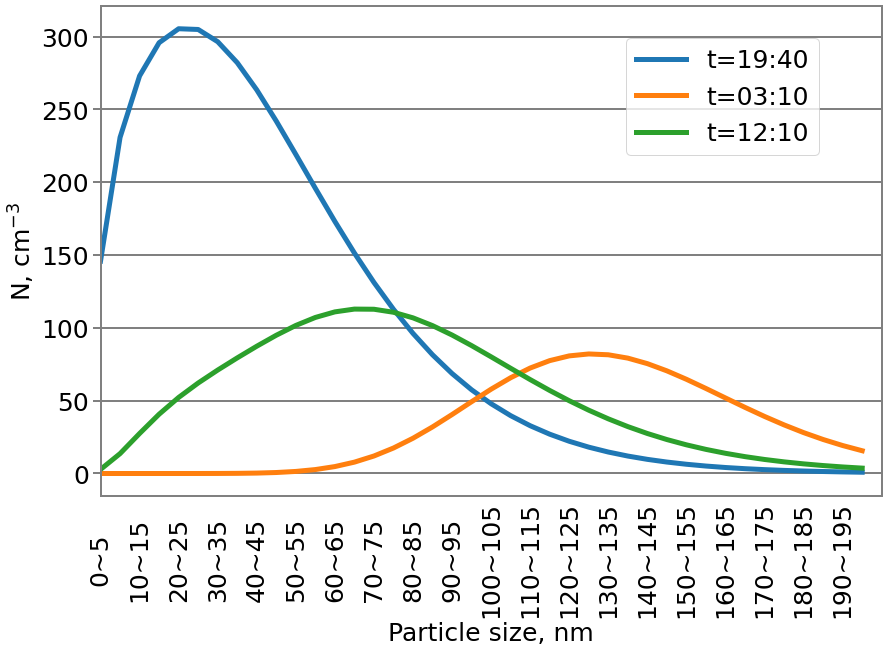

In [116]:
#THIS IS BASED ON SMOOTH SIN

fig, ax1 = plt.subplots(figsize=(14,9))

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

vss = [45, 90, 144]

print(len(dt_time))


normed_dd = dd[:,:].astype(float)

ax1.plot(normed_dd[vss[0], :], color='C0', label="t="+str(dt_time[vss[0]]), lw=5)
ax1.plot(normed_dd[vss[1], :], color='C1', label="t="+str(dt_time[vss[1]]), lw=5)
ax1.plot(normed_dd[vss[2], :], color='C2',label="t="+str(dt_time[vss[2]]), lw=5)

ax1.set_ylabel("N, cm$^{-3}$", fontsize=25,color='black')
ax1.set_xlabel("Particle size, nm", fontsize=25, color='black')

ax1.grid(axis='y', lw=2, color='grey')

ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax1.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

#ax1.set_xlim([0,1])
#ax1.set_ylim([0.0,1600])

ax1.set_xticks(ticks=sp_ticks_pos[::2], labels=sp_ticks[::2], va='center')
ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=55)

plt.xlim(0,40)
fig.legend(fontsize=25, bbox_to_anchor=(0.35, 0.35, 0.5, 0.5))
plt.savefig("spectra.pdf", bbox_inches='tight', format='pdf')

290 580 929
(15,)


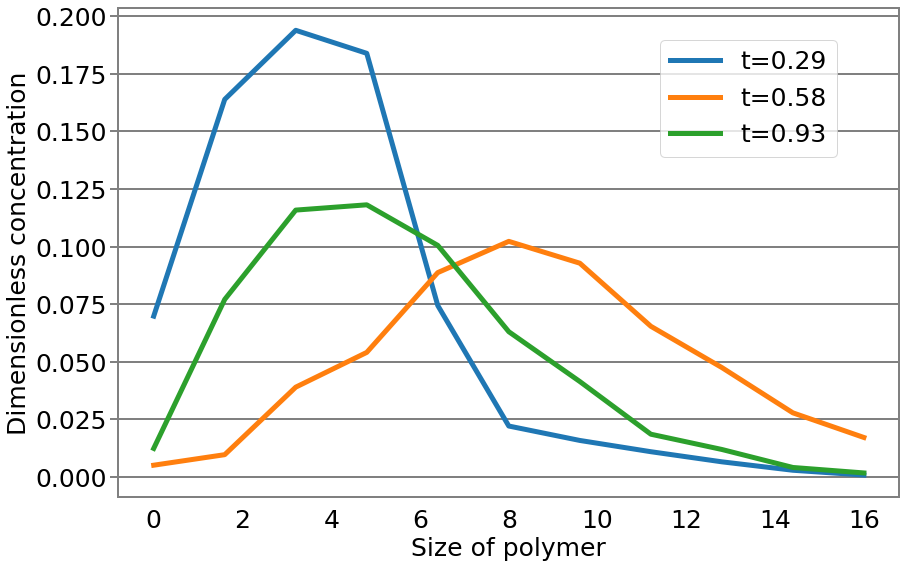

In [117]:
#THIS IS BASED ON SMOOTH SIN

fig, ax1 = plt.subplots(figsize=(14,9))

vs = [0.,0.,0.]
vs[0] = int(vss[0]/155.*1000)
vs[1] = int(vss[1]/155.*1000)
vs[2] = int(vss[2]/155.*1000)

print(vs[0], vs[1], vs[2])


vv2=18

y1 = y[st+100:en, vv2, :]
y2 = np.flip(y[st-100:st, vv2, :], axis=0)
sizes = np.vstack([y1,y2])


plt.yticks(fontsize=25)
plt.xticks(fontsize=25)


normed = sizes[:,:60]
normed_ma = np.zeros((1000,normed.shape[1]-1))
normed_new = np.zeros((1000,100))
for i in range(normed.shape[0]):
    normed[i] = normed[i]/normed[i].sum()
    normed_ma[i] = moving_average(normed[i],2)
    xx = np.arange(len(normed_ma[i]))
    xxx = np.linspace(0, len(normed_ma[i])-1, 100)
    f = interpolate.interp1d(xx, normed_ma[i])
    normed_new[i]=f(xxx)

xx=np.linspace(0,20,100)

fix = normed_new[vs[0], 5:50:3]
fix[3]=fix[4]+0.01
fix[2]=fix[3]-0.03
fix = normed_new[vs[1], 5:50:3]
fix[4] +=0.01
print(fix.shape)


x = np.linspace(0, 16, normed_new[vs[0], 8:40:3].shape[0])
ax1.plot(x, normed_new[vs[0], 8:40:3], color='C0', label="t="+str(round((vs[0])*0.001,2)), lw=5)
ax1.plot(x, normed_new[vs[1], 8:40:3], color='C1', label="t="+str(round((vs[1])*0.001,2)), lw=5)
ax1.plot(x, normed_new[vs[2], 8:40:3], color='C2',label="t="+str(round((vs[2])*0.001,2)), lw=5)

ax1.set_ylabel("Dimensionless concentration", fontsize=25)
ax1.set_xlabel("Size of polymer", fontsize=25)

ax1.grid(axis='y', lw=2, color='grey')

ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax1.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

fig.legend(fontsize=25, bbox_to_anchor=(0.35, 0.35, 0.5, 0.5))
plt.savefig("num_spectra.pdf", bbox_inches='tight', format='pdf')


